### Sensors

In [40]:
import os.path as op
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from base import ensure_dir
from config import *
import gc
import os
import sys
import os

# params
subjects = SUBJS
subject = subjects[0]
lock = "stim"
trial_type = 'pattern'

data_path = DATA_DIR
subjects_dir = FREESURFER_DIR
folds = 10
solver = 'lbfgs'
scoring = "accuracy"

is_cluster = os.getenv("SLURM_ARRAY_TASK_ID") is not None
overwrite = False
verbose = True
jobs = -1

epoch_num = 1

In [41]:
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=jobs))
# clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=-1))
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose)
cv = StratifiedKFold(folds, shuffle=True, random_state=42)

In [58]:
epo_dir = TIMEG_DATA_DIR / 'rdm_bsling' / lock
epo_fnames = [epo_dir / f'{f}' for f in sorted(os.listdir(epo_dir)) if '.fif' in f and subject in f]
all_epo = [mne.read_epochs(fname, preload=True, verbose="error") for fname in epo_fnames]
for epoch in all_epo: # see mne.preprocessing.maxwell_filter to realign the runs to a common head position. On raw data.
    epoch.info['dev_head_t'] = all_epo[0].info['dev_head_t']
epoch = mne.concatenate_epochs(all_epo, on_mismatch='raise')

beh_dir = data_path / 'behav'
beh_fnames = [beh_dir / f'{f}' for f in sorted(os.listdir(beh_dir)) if '.pkl' in f and subject in f]
all_beh = [pd.read_pickle(fname) for fname in beh_fnames]
behav = pd.concat(all_beh)

network = NETWORKS[0]
label_path = RESULTS_DIR / 'networks_200_7' / subject
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')


Not setting metadata
1007 matching events found


ValueError: Baseline interval [-1.7000000476837158, -1.5] s is outside of epochs data [-0.19660753305710899, 0.5996529758241824] s. Epochs were probably cropped.

In [43]:
pattern = behav.trialtypes == 1
X = epoch.get_data()[pattern][:500]
y = behav.positions[pattern][:500]
sensor_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

/var/folders/0x/4l778zdn0l524g42s5_nc48h0000gn/T/ipykernel_3046/2308183527.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epoch.get_data()[pattern][:500]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished


In [ ]:
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter

pca = UnsupervisedSpatialFilter(PCA(1000), average=False)
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="auto", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="auto", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori=None, weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(lh_label + rh_label).data) for stc in stcs])
# stcs_data = pca.fit_transform(data)
stcs_data = data.copy()

Reducing data rank from 246 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 85746
log-likelihood on unseen data (descending order):
   shrunk: -1285.063
   empirical: -1285.287
   diagonal_fixed: -1375.079
selecting best estimator: shrunk
[done]
Reducing data rank from 246 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 29043
log-likelihood on unseen data (descending order):
   shrunk: -1210.819
   empirical: -1210.979
   

In [45]:
pattern = behav.trialtypes == 1
X = stcs_data[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
none_sc = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


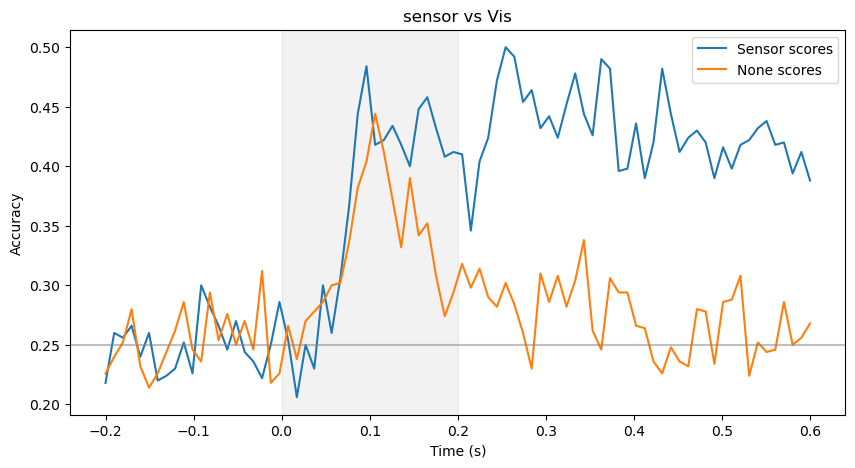

In [ ]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='Sensor scores')
ax.plot(times, none_sc.mean(0), label='auto none reduced scores')
# ax.plot(times, vector_red_sc.mean(0), label='Vector - reduced - scores')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
ax.axvspan(0, 0.2, color='grey', alpha=0.1)
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.set_title(f'sensor vs {network}')
ax.legend()

In [48]:
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="auto", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="auto", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori=None, weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=False, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(lh_label + rh_label).data) for stc in stcs])
# stcs_data = pca.fit_transform(data)
stcs_data = data.copy()
pattern = behav.trialtypes == 1
X = stcs_data[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
none_sc_nored = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Reducing data rank from 246 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 85746
log-likelihood on unseen data (descending order):
   shrunk: -1285.063
   empirical: -1285.287
   diagonal_fixed: -1375.079
selecting best estimator: shrunk
[done]
Reducing data rank from 246 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 29043
log-likelihood on unseen data (descending order):
   shrunk: -1210.819
   empirical: -1210.979
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   52.9s finished


In [50]:
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori=None, weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=False, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(lh_label + rh_label).data) for stc in stcs])
# stcs_data = pca.fit_transform(data)
stcs_data = data.copy()
pattern = behav.trialtypes == 1
X = stcs_data[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
none_emp_sc_nored = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 85746
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 29043
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 246 dim * 3.1  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub01-1-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spaces

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.7s finished


In [51]:
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori=None, weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(lh_label + rh_label).data) for stc in stcs])
# stcs_data = pca.fit_transform(data)
stcs_data = data.copy()
pattern = behav.trialtypes == 1
X = stcs_data[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
none_emp_sc_red = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 85746
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 29043
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 246 dim * 3.1  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub01-1-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spaces

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


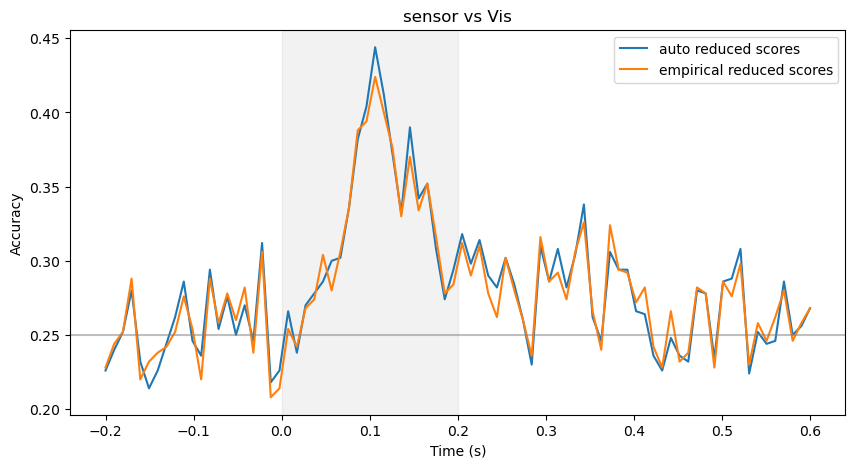

In [60]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(times, sensor_scores.mean(0), label='Sensor scores')
ax.plot(times, none_sc.mean(0), label='auto reduced scores')
ax.plot(times, none_emp_sc_red.mean(0), label='empirical reduced scores')
# ax.plot(times, none_sc_nored.mean(0), label='auto no reduced scores')
# ax.plot(times, none_emp_sc_nored.mean(0), label='empirical no reduced scores')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
ax.axvspan(0, 0.2, color='grey', alpha=0.1)
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.set_title(f'sensor vs {network}')
ax.legend()

In [36]:
def svd(vector_data):
    # Initialize an array for storing the dominant orientation time series
    dominant_data = np.zeros((vector_data.shape[0], vector_data.shape[1], vector_data.shape[-1]))  # (294, 8196, 82)
    for trial in range(vector_data.shape[0]):  # Loop over trials
        for source in range(vector_data.shape[1]):  # Loop over sources
            u, s, vh = np.linalg.svd(vector_data[trial, source, :, :], full_matrices=False)  # SVD over orientation axis (3)
            dominant_time_series = vh[0, :] * s[0]  # First right singular vector weighted by singular value
            dominant_data[trial, source, :] = dominant_time_series  # Store in new array
    return dominant_data

In [37]:
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter

pca = UnsupervisedSpatialFilter(PCA(1000), average=False)
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-{epoch_num}-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori='vector', weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(lh_label + rh_label).data) for stc in stcs])

data = svd(data)

# stcs_data = pca.fit_transform(data)
stcs_data = data.copy()
pattern = behav.trialtypes == 1
X = stcs_data[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
vector_red_sc = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 103540
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 35070
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 246 dim * 2.8  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub02-1-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8195 sources, 246 channels, free orientations)
    Source space

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.5s finished


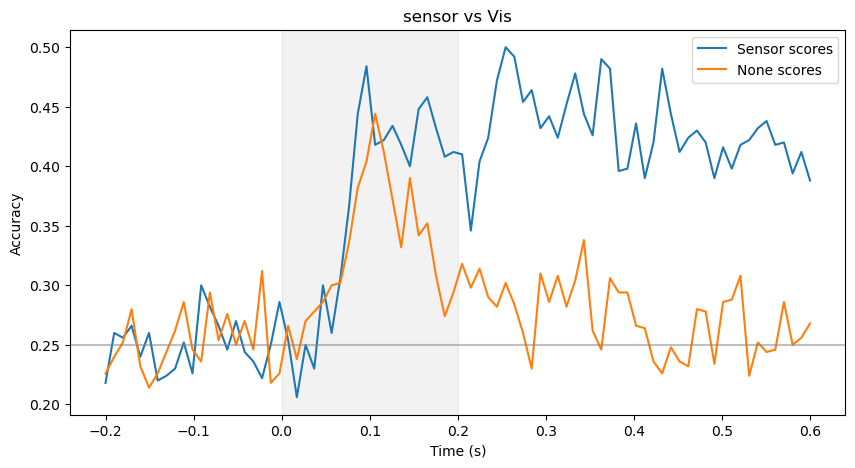